# Usage:  SEPIA@QSPICE

In your target VRM test bench / schematic, place the SEPIA@QSPICE block in this way.

[!IMPORTANT]  
**Strongly recommended** to copy&paste the module from this example [QSPICE schematic](Zo_SEPIA0.qsch).  
These 4 lines of sub-circuit parameters must follow a specific order, that is aligned to the declaration order of the SEPIA@QSPICE module.

<img src="Image/Schematic.png" />

## I/O

### IN

This is the VRM output voltage (= step response) monitoring input port.  
From this signal input, the SEPIA@QSPICE detects ringing peaks.

### CTRL

This is the control signal output port into an external VCCS (Voltage-controlled Current-source).
At the parameter specified timing (see parameters section), it activate the VCCS step load from L to H.

### CLK

This is the sampling clock input port.
This port is provided for a test of SMPS (Switch-Mode Power Suppy) / switching regulators.
Connect this port to a PWM signal source of your switching VRM.

When testing linear regualtors / LDOs, you need to place an oscilator / pulse voltage source, as shown in the schematic above, pick up the clock frequency x10 or more of expected loop B/W of your DUT VRM.

### Out0

This port outputs internal processing information.  
While your VRM ringing is there, it outputs a derivative of V(IN) = d(V(IN))/dt.  
Once enough ringing detected, it outputs volatage difference between steady-state pre-step average volage and steady-state post-step average voltage = load regulation ΔV(IN).

### Out1

This port outputs internal processing information.  
It outputs internal peak tracing status.

Note that this port output has a certain amount of delay from a filter inside, so to detect true peak.
Inside the SEPIA@QSPICE, we use true peak infomration without any delay, by utilizing software memory/buffer, but this "real time output signal" **Out1** has delay.


## Example 1:  SEPIA@QSPICE I/O Signals

Below simulation illustrates how each I/o signal working on a real simulation.

Slope of the purple tangent line =  15151.51515151498


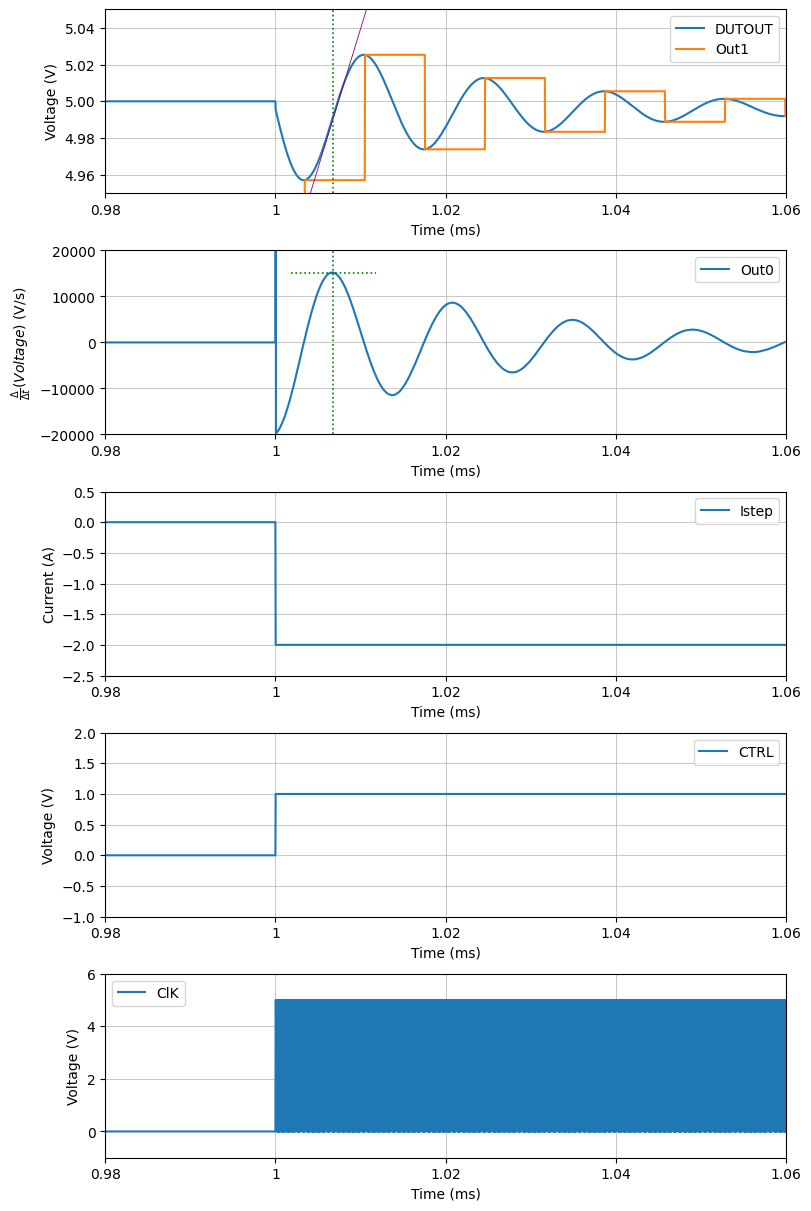

In [1]:
from PyQSPICE import clsQSPICE as pqs

import re
import subprocess
import math
import cmath

import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as pat
from matplotlib.transforms import ScaledTranslation as stran

import numpy as np
from numpy import sin, cos, pi, linspace

fname = "Zo_SEPIA0"
run = pqs(fname)
run.qsch2cir()
run.cir4label('tran')

Ndata = 1024 * 64
run.selectSimLabel('tran', Nline = Ndata, Nbit = 80)

run.opt4SEPIA(run.path['tran.cir'], Verbose = True)
    
run.cir2qraw()
#run.copy2qraw()  #use this line to re-use existing QRAW file

Vout  = "V(dutout)"
Istep = "I(G1)"
Out0  = "V(o0)"
Out1  = "V(o1)"
Ctrl  = "V(ctrl)"
Clk   = "V(clk)"

dfTRAN = run.LoadQRAW([Vout, Istep, Out0, Out1, Clk, Ctrl])

plt.close('all')

fig, ax = plt.subplots(5, 1, constrained_layout=True, figsize=(8,12))

dfTRAN.plot(ax=ax[0], x="Time", y=Vout, label="DUTOUT")
dfTRAN.plot(ax=ax[0], x="Time", y=Out1, label="Out1")
dfTRAN.plot(ax=ax[1], x="Time", y=Out0, label="Out0")
dfTRAN.plot(ax=ax[2], x="Time", y=Istep, label="Istep")
dfTRAN.plot(ax=ax[3], x="Time", y=Ctrl, label="CTRL")
dfTRAN.plot(ax=ax[4], x="Time", y=Clk, label="ClK")

xrange = [0.98e-3,1.05e-3]
y1 = 4.95
y2 = 5.05
yrang1 = [y1,y2]
yrang2 = [-20e3,20e3]

run.PrepTimePlot(ax[0], "Time", r"Voltage (V)", xrange, yrang1, "")
run.PrepTimePlot(ax[1], "Time", r"$\frac{\Delta}{\Delta t}(Voltage)$ (V/s)", xrange, yrang2, "")
run.PrepTimePlot(ax[2], "Time", r"Current (A)", xrange, [-2.5,0.5], "")
run.PrepTimePlot(ax[3], "Time", r"Voltage (V)", xrange, [-1,2], "")
run.PrepTimePlot(ax[4], "Time", r"Voltage (V)", xrange, [-1,6], "")

x1 = 1.0041e-3
x2 = 1.0107e-3
ax[0].plot([x1,x2],yrang1, linewidth=0.6, color="purple")

slope = (y2 - y1) / (x2 - x1)
print("Slope of the purple tangent line = ", str(slope))

x3 = 1.0068e-3

ax[0].plot([x3,x3],yrang1, linewidth=1.2, color="green", linestyle="dotted")
ax[1].plot([x3,x3],yrang2, linewidth=1.2, color="green", linestyle="dotted")
ax[1].plot([x3-5e-6,x3+5e-6],[slope,slope], linewidth=1.2, color="green", linestyle="dotted")

plt.savefig("plot1.png", format='png', bbox_inches='tight')

plt.show()


### Internal Signal Monitors:  Out0 & Out1

In above plot, we can observe how the two internal signals **Out0** and **Out1** tracing the **DUTOUT** ringing waveforms.

The **Out1** waveform traces the peaks of **DUTOUT** (with a delay, see next plot).  
Check the purple tangentline and it's slope value printed, plus green guide lines.

The **Out0** waveform is a time derivative of **DUTOUT** where the SEPIA@QSPICE block uses to find peaks at this curve crossing zero **"0"**.  
We can see that the first peak is matching to the purple tangent line and its slope value.

### VCCS Control Signal:  CTRL

The **Ctrl** signal goes into a Voltage-Control Current-Source element.  The gain of VCCS is set by a parameter **{Istep}**, so the SEPIA@QSPICE block just send High/Low from **0** to **1**.

### Sampling Clock:  Clk

The SEPIA@QSPICE block uses this **Clk** as a sampling clock of internal (noise, glitch) filter.  
When testing a switching regulator, this sampling-clock-bse filter improves accuracy of peak detection by reducing influence of switching ripple .  Check the next plot.

## Example 2:  SEPIA@QSPICE I/O Signals with Slower Sampling Clock

Below simulation is identical to the previous one but only difference of slower sampling clock.

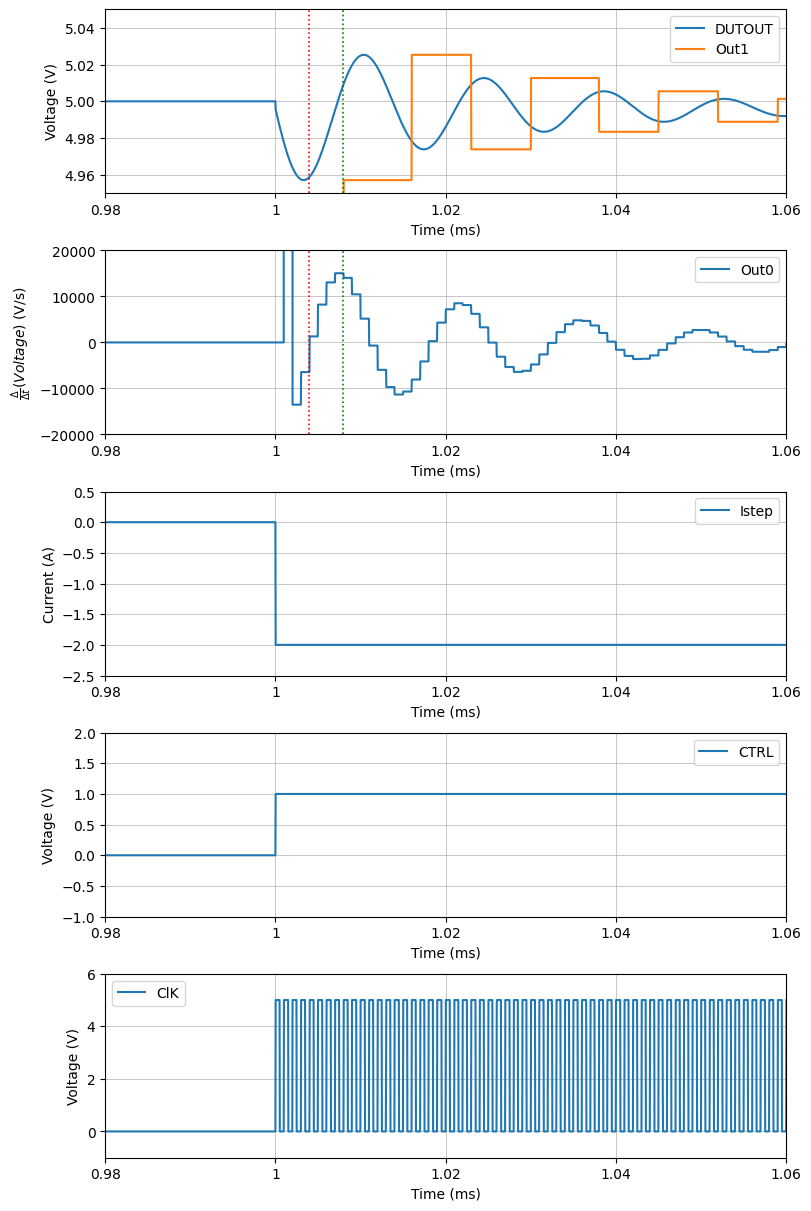

In [2]:
fname2 = "Zo_SEPIA0a"
run2 = pqs(fname2)
run2.qsch2cir()
run2.cir4label('tran')

Ndata = 1024 * 64
run2.selectSimLabel('tran', Nline = Ndata, Nbit = 80)

run2.opt4SEPIA(run2.path['tran.cir'], Verbose = True)
    
run2.cir2qraw()
#run.copy2qraw()  #use this line to re-use existing QRAW file

Vout  = "V(dutout)"
Istep = "I(G1)"
Out0  = "V(o0)"
Out1  = "V(o1)"
Ctrl  = "V(ctrl)"
Clk   = "V(clk)"

dfTRAN2 = run2.LoadQRAW([Vout, Istep, Out0, Out1, Clk, Ctrl])

plt.close('all')

fig, ax = plt.subplots(5, 1, constrained_layout=True, figsize=(8,12))

dfTRAN2.plot(ax=ax[0], x="Time", y=Vout, label="DUTOUT")
dfTRAN2.plot(ax=ax[0], x="Time", y=Out1, label="Out1")
dfTRAN2.plot(ax=ax[1], x="Time", y=Out0, label="Out0")
dfTRAN2.plot(ax=ax[2], x="Time", y=Istep, label="Istep")
dfTRAN2.plot(ax=ax[3], x="Time", y=Ctrl, label="CTRL")
dfTRAN2.plot(ax=ax[4], x="Time", y=Clk, label="ClK")

xrange = [0.98e-3,1.05e-3]
y1 = 4.95
y2 = 5.05
yrang1 = [y1,y2]
yrang2 = [-20e3,20e3]

run2.PrepTimePlot(ax[0], "Time", r"Voltage (V)", xrange, yrang1, "")
run2.PrepTimePlot(ax[1], "Time", r"$\frac{\Delta}{\Delta t}(Voltage)$ (V/s)", xrange, yrang2, "")
run2.PrepTimePlot(ax[2], "Time", r"Current (A)", xrange, [-2.5,0.5], "")
run2.PrepTimePlot(ax[3], "Time", r"Voltage (V)", xrange, [-1,2], "")
run2.PrepTimePlot(ax[4], "Time", r"Voltage (V)", xrange, [-1,6], "")

x1 = 1.0039e-3
x2 = 1.0079e-3

ax[0].plot([x1,x1],yrang1, linewidth=1.2, color="red", linestyle="dotted")
ax[1].plot([x1,x1],yrang2, linewidth=1.2, color="red", linestyle="dotted")

ax[0].plot([x2,x2],yrang1, linewidth=1.2, color="green", linestyle="dotted")
ax[1].plot([x2,x2],yrang2, linewidth=1.2, color="green", linestyle="dotted")

plt.savefig("plot2.png", format='png', bbox_inches='tight')

plt.show()


### Filter and Sampling Clock

The above plot clearly shows how SEPIA@QSPICE filter, based on the sampling clock input, works.  Focus on the **red** and **green** guidelines.

The block detects a peak with 5-sampling-clock delay.  After a zero-crossing event of the **Out0** waveform, the block holds its decision until no another zero-crossing for 5 sampling clock period and calls it a "peak".

Note that, inside the block, a buffer memory records the peak value and pricise time of the peak, just the decision gets delayed.